In [80]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
#from sklearn.preprocessing import PolynomialFeatures
from multiprocessing import Pool
import multiprocessing
import ZVnbrosse
from potentials import GaussPotential,GaussMixture,GausMixtureIdent,GausMixtureSame
from zv_cv import Eval_ZVCV
from samplers import MCMC_sampler,Generate_train,ULA_light
from baselines import set_function,construct_ESVM_kernel,GenerateSigma, construct_Tukey_Hanning 
from martingale import approx_q,test_traj
from optimize import Run_eval_test,optimize_parallel_new 
from utils import *
import copy

In [81]:
N_burn = 1*10**4 # Burn in period
N_train = 1*10**5 # Number of samples on which we optimize
#N_test = 2*10**3 # Number of samples
step = 0.1 # Step size
#step = 0.2
n_traj = 100 # Number of independent MCMC trajectories for test

Choose sampler type (currently only ULA is maintained)

In [82]:
d = 2
mu = 0.5*np.ones(d,dtype = float)
#mu_1 = np.array([-1.0])
#mu_2 = np.array([1.0])
#Sigma_1 = np.array([[1.0]])
#Sigma_2 = np.array([[1.0]])
Sigma = GenerateSigma(d,rand_seed = 778,eps = 0.1) #covariance matrix 
p = 0.5
Cur_pot = GausMixtureSame(Sigma,mu,p)
#Cur_pot = GaussMixture(Sigma_1,Sigma_2,mu_1,mu_2,p)
#Cur_pot = GausMixtureIdent(mu,p)
r_seed = 777
x0 = np.array([0.0,0.0])
fixed_start = True
bn = int(np.sqrt(N_train))
W_test = construct_Tukey_Hanning(N_train,bn)

[0.44449977 3.48642106]


### Generate data

In [83]:
sampler = {"sampler":"RWM","burn_type":"full","main_type":"full"} # Sampling method

if sampler["sampler"] == "ULA":
    res = Generate_train(n_traj, sampler, Cur_pot, step, N_burn, N_train, d)
    res = np.asarray(res)
    traj,traj_grad = res[:,0,:,:],res[:,1,:,:]
else:
    res = Generate_train(n_traj, sampler, Cur_pot, step, N_burn, N_train, d)
    traj = []
    traj_grad = []
    for i in range(len(res)):
        traj.append(res[i][0])
        traj_grad.append(res[i][1])
        print("accepted = ",res[i][2])
    traj = np.asarray(traj)
    traj_grad = np.asarray(traj_grad)

ncores =  12
accepted =  82233
accepted =  82086
accepted =  82064
accepted =  82189
accepted =  82085
accepted =  82162
accepted =  82450
accepted =  82559
accepted =  82364
accepted =  82483
accepted =  82176
accepted =  81989
accepted =  81991
accepted =  82300
accepted =  82329
accepted =  82275
accepted =  82004
accepted =  82359
accepted =  82119
accepted =  82283
accepted =  82226
accepted =  82320
accepted =  81949
accepted =  82565
accepted =  82094
accepted =  82270
accepted =  82185
accepted =  82156
accepted =  82197
accepted =  82385
accepted =  82063
accepted =  82421
accepted =  82274
accepted =  82257
accepted =  82198
accepted =  82315
accepted =  82541
accepted =  82214
accepted =  82217
accepted =  82335
accepted =  82421
accepted =  82059
accepted =  82520
accepted =  82384
accepted =  82271
accepted =  82570
accepted =  82167
accepted =  82088
accepted =  82045
accepted =  82299
accepted =  82432
accepted =  82378
accepted =  82175
accepted =  82341
accepted =  821

In [84]:
print(traj.shape)
print(traj_grad.shape)
traj_grad = (-1)*traj_grad

(100, 100000, 2)
(100, 100000, 2)


In [85]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
f_type = "sum_comps"
params = {"ind":0}
trav = Pool(nbcores)
res = trav.starmap(Eval_ZVCV, [(traj[i,:,:],traj_grad[i,:,:],f_type,params,W_test) for i in range (n_traj)])
trav.close()

CV1:  [[ 0.92871284]
 [-0.5806815 ]]
CV1:  [[ 0.89416526]
 [-0.50518948]]
CV1:  [[ 0.93619739]
 [-0.54538029]]
CV1:  [[ 0.90646698]
 [-0.53963526]]
CV1:  [[ 0.95705701]
 [-0.57829373]]CV1:  [[ 0.9072232 ]
 [-0.52534056]]

CV1:  [[ 0.90784625]
 [-0.53707499]]
CV1:  [[ 0.91478911]
 [-0.55016107]]CV1:  [[ 0.89567858]
 [-0.50963289]]

CV1:  [[ 0.91093509]
 [-0.53046861]]
CV1:  [[ 0.92089269]
 [-0.54401383]]
CV1:  [[ 0.92134391]
 [-0.58538907]]
CV1:  [[ 0.92674146]
 [-0.56880457]]
CV1:  [[ 0.92191507]
 [-0.535588  ]]
CV1:  [[ 0.94334945]
 [-0.53974139]]
CV1:  [[ 0.93752078]
 [-0.58554909]]
CV1:  [[ 0.90897766]
 [-0.51203078]]
CV1:  [[ 0.93027445]
 [-0.55776907]]
CV1:  [[ 0.93529801]
 [-0.53969913]]
CV1:  [[ 0.87953215]
 [-0.46827233]]
CV1:  [[ 0.89754999]
 [-0.53432698]]
CV1:  [[ 0.92310804]
 [-0.58429916]]
CV1:  [[ 0.88126689]
 [-0.51184081]]
CV1:  [[ 0.91421799]
 [-0.50228128]]
CV1:  [[ 0.92083214]
 [-0.5222899 ]]
CV1:  [[ 0.91488857]
 [-0.54231099]]
CV1:  [[ 0.91685224]
 [-0.52518014]]
C

In [86]:
res_arr = np.asarray(res)
print(res_arr.shape)

(100, 2, 5)


### VR rates

In [87]:
#np.save("results/gmm/RWM_quadratic_d_2_mu_05_sigma_mixed_gamma_01_25_06.npy",res_arr)
print("Average vr rates:")
print("ZV-1:",np.mean(res_arr[:,1,0]/res_arr[:,1,1]))
print("CV-1:",np.mean(res_arr[:,1,0]/res_arr[:,1,3]))
print("ZV-2:",np.mean(res_arr[:,1,0]/res_arr[:,1,2]))
print("CV-2:",np.mean(res_arr[:,1,0]/res_arr[:,1,4]))

Average vr rates:
ZV-1: 99.95102914390111
CV-1: 94.96178465582898
ZV-2: 100.34237344327323
CV-2: 105.14962348741602


### Comparison plots

In [88]:
title = ""
labels = ['Vanilla\n RWM', 'RWM \nwith ZV-1', 'RWM \nwith CV-1']

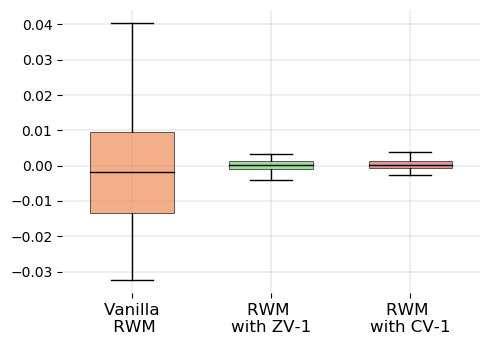

In [89]:
data = [res_arr[:,0,0],res_arr[:,0,1],res_arr[:,0,3]] 
boxplot_ind(data, title, labels, path = "results/gmm/rwm_mixed_1.pdf")

In [90]:
title = ""
labels = ['Vanilla\n RWM', 'RWM \nwith ZV-2', 'RWM \nwith CV-2']

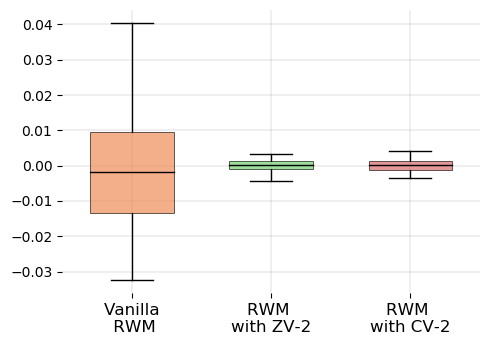

In [91]:
data = [res_arr[:,0,0],res_arr[:,0,2],res_arr[:,0,4]] 
boxplot_ind(data, title, labels, path = "results/gmm/rwm_mixed_2.pdf")